[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

#  Regularized Training

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 04/07/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0097DeepLearningRegularizedTraining.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
import torchvision
from torchvision.transforms import v2 as TorchVisionTrns

# Miscellaneous
import copy
from enum import auto, Enum, unique
import math
import os
from platform import python_version
import random
import shutil
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

2024-06-14 06:48:47.888745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility (Per PyTorch Version on the same device)
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False #<! Makes things slower


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

DATA_SET_FILE_NAME      = 'archive.zip'
DATA_SET_FOLDER_NAME    = 'IntelImgCls'

D_CLASSES  = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}
L_CLASSES  = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
T_IMG_SIZE = (32, 32, 3)

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [4]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [5]:
# Courses Packages
import sys
sys.path.append('../../utils')
sys.path.append('/home/vlad/utils')
from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import ResidualBlock, TBLogger, TestDataSet
from DeepLearningPyTorch import GenDataLoaders, InitWeightsKaiNorm, TrainModel, TrainModelSch


In [6]:
# General Auxiliary Functions

def GenResNetModel( trainedModel: bool, numCls: int, resNetDepth: int = 18 ) -> nn.Module:
    # Read on the API change at: How to Train State of the Art Models Using TorchVision’s Latest Primitives
    # https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives

    if (resNetDepth == 18):
        modelFun = torchvision.models.resnet18
        modelWeights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
    elif (resNetDepth == 34):
        modelFun = torchvision.models.resnet34
        modelWeights = torchvision.models.ResNet34_Weights.IMAGENET1K_V1
    else:
        raise ValueError(f'The `resNetDepth`: {resNetDepth} is invalid!')

    if trainedModel:
        oModel = modelFun(weights = modelWeights)
        numFeaturesIn   = oModel.fc.in_features
        # Assuming numCls << 100
        oModel.fc       = nn.Sequential(
            nn.Linear(numFeaturesIn, 128), nn.ReLU(),
            nn.Linear(128, numCls),
        )
    else:
        oModel = modelFun(weights = None, num_classes = numCls)

    return oModel



## Regularized Training

This notebook combines several regularization methods in order to maximize the **validation score**.


This notebook demonstrate:
 - Using data augmentation using _CutMix_.
 - Using _Label Smoothing_.

</br>



In [7]:
# Parameters

# Data

# Model
dropP = 0.5 #<! Dropout Layer

# Training
batchSize   = 256
numWorkers  = 4 #<! Number of workers
numEpochs   = 35
ϵ = 0.1 #<! Label Smoothing

# Visualization
numImg = 3


## Generate / Load Data

Load the [CIFAR 10 Data Set](https://en.wikipedia.org/wiki/CIFAR-10).  
It is composed of 60,000 RGB images of size `32x32` with 10 classes uniformly spread.

* <font color='brown'>(**#**)</font> The dataset is retrieved using [Torch Vision](https://pytorch.org/vision/stable/index.html)'s built in datasets.  


In [8]:
# Load Data

dsTrain = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = True,  download = True, transform = torchvision.transforms.ToTensor())
dsVal   = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = False, download = True, transform = torchvision.transforms.ToTensor())
lClass  = dsTrain.classes


print(f'The training data set data shape: {dsTrain.data.shape}')
print(f'The test data set data shape: {dsVal.data.shape}')
print(f'The unique values of the labels: {np.unique(lClass)}')

Files already downloaded and verified
Files already downloaded and verified
The training data set data shape: (50000, 32, 32, 3)
The test data set data shape: (10000, 32, 32, 3)
The unique values of the labels: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


* <font color='brown'>(**#**)</font> The dataset is indexible (Subscriptable). It returns a tuple of the features and the label.
* <font color='brown'>(**#**)</font> While data is arranged as `H x W x C` the transformer, when accessing the data, will convert it into `C x H x W`. 

In [9]:
# Element of the Data Set

mX, valY = dsTrain[0]

print(f'The features shape: {mX.shape}')
print(f'The label value: {valY}')

The features shape: torch.Size([3, 32, 32])
The label value: 6


### Plot the Data

In [10]:
# Extract Data

tX = dsTrain.data #<! NumPy Tensor (NDarray)
mX = np.reshape(tX, (tX.shape[0], -1))
vY = dsTrain.targets #<! NumPy Vector


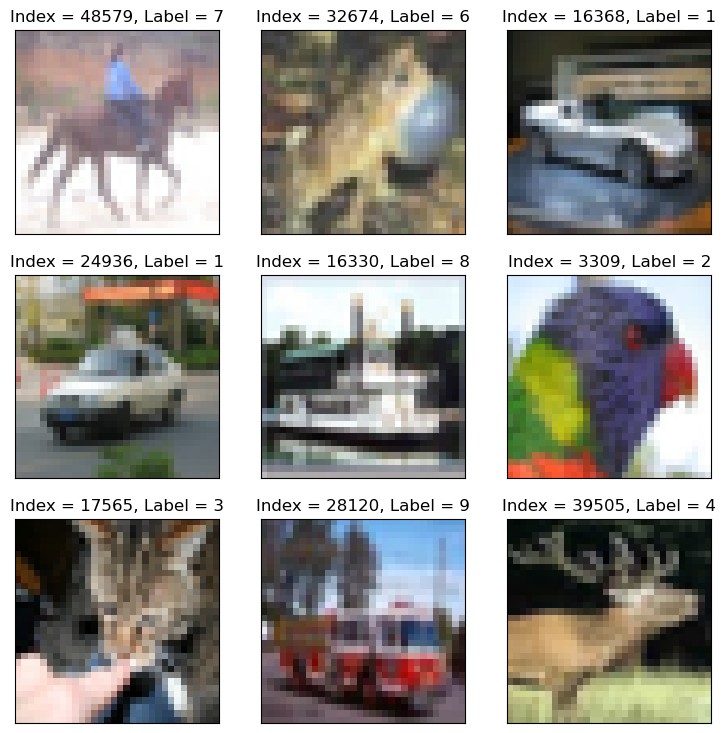

In [11]:
# Plot the Data

hF = PlotMnistImages(mX, vY, numImg, tuImgSize = T_IMG_SIZE)

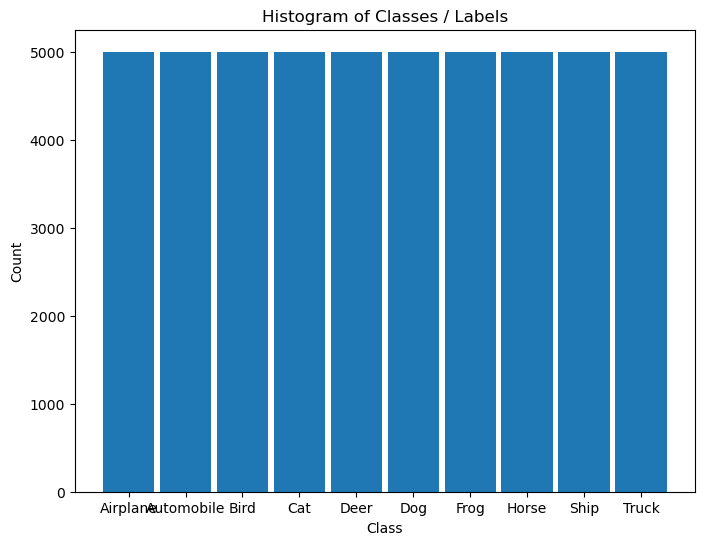

In [12]:
# Histogram of Labels

hA = PlotLabelsHistogram(vY, lClass = L_CLASSES)
plt.show()

* <font color='red'>(**?**)</font> If data is converted into _grayscale_, how would it effect the performance of the classifier? Explain.  
  You may assume the conversion is done using the mean value of the RGB pixel.

## Pre Process Data

This section normalizes the data to have zero mean and unit variance per **channel**.  
It is required to calculate:

 * The average pixel value per channel.
 * The standard deviation per channel.

</br>

* <font color='brown'>(**#**)</font> The values calculated on the train set and applied to both sets.
* <font color='brown'>(**#**)</font> The the data will be used to pre process the image on loading by the `transformer`.
* <font color='brown'>(**#**)</font> There packages which specializes in transforms: [`Kornia`](https://github.com/kornia/kornia), [`Albumentations`](https://github.com/albumentations-team/albumentations).  
  They are commonly used for _Data Augmentation_ at scale.

In [13]:
# Calculate the Standardization Parameters
vMean = np.mean(dsTrain.data / 255.0, axis = (0, 1, 2))
vStd  = np.std(dsVal.data / 255.0, axis = (0, 1, 2))

print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24665252 0.24289226 0.26159238]


In [14]:
# Update Transformer

oTrnsTrain = TorchVisionTrns.Compose([
    TorchVisionTrns.RandomHorizontalFlip(), #<! Can be done in UINT8 for faster performance
    TorchVisionTrns.AutoAugment(policy = TorchVisionTrns.AutoAugmentPolicy.CIFAR10), #<! Requires `UINT8`
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.Normalize(vMean, vStd)
])

oTrnsInfer = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.Normalize(vMean, vStd)
])

# Update the DS transformer
dsTrain.transform   = oTrnsTrain
dsVal.transform     = oTrnsInfer

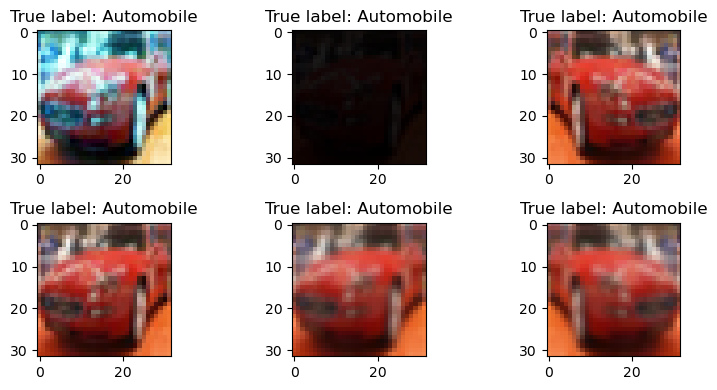

In [15]:
# "Normalized" Image

imgIdx = 5


N, H, W, C = dsTrain.data.shape
hF, vHA = plt.subplots(2, 3, figsize = (8, 4))
vHA = vHA.flat
for hA in vHA:
    mX, valY = dsTrain[imgIdx] #<! Random
    mX = torch.permute(mX, (1, 2, 0))
    hA.imshow(torch.clip(mX * vStd[None, None, :] + vMean[None, None, :], min = 0.0, max = 1.0))
    hA.set_title(f'True label: {L_CLASSES[valY]}')
    
hF.tight_layout()


### Data Loaders

This section defines the data loaded.



In [16]:
# Data Loader

dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = 2, drop_last = True, persistent_workers = True)
dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = 2, persistent_workers = True)

# dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = 0, drop_last = True)
# dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = 0)


In [17]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 3, 32, 32])
The batch labels dimensions: torch.Size([256])


In [18]:
# Looping
# for ii, (tX, vY) in zip(range(1), dlVal): #<! https://stackoverflow.com/questions/36106712
#     print(f'The batch features dimensions: {tX.shape}')
#     print(f'The batch labels dimensions: {vY.shape}')

## Load the Model

This section loads the model.  
The number of outputs is adjusted to match the number of classes in the data.

In [19]:
# Loading a Pre Defined Model
oModel = GenResNetModel(trainedModel = False, numCls = len(L_CLASSES))
# oModel.apply(InitWeightsKaiNorm)

In [20]:
# Model Information - Pre Defined
# Pay attention to the layers name.
torchinfo.summary(oModel, (batchSize, *(T_IMG_SIZE[::-1])), col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu', row_settings = ['depth', 'var_names'])

Layer (type (var_name):depth-idx)             Kernel Shape              Output Shape              Param #
ResNet (ResNet)                               --                        [256, 10]                 --
├─Conv2d (conv1): 1-1                         [7, 7]                    [256, 64, 16, 16]         9,408
├─BatchNorm2d (bn1): 1-2                      --                        [256, 64, 16, 16]         128
├─ReLU (relu): 1-3                            --                        [256, 64, 16, 16]         --
├─MaxPool2d (maxpool): 1-4                    3                         [256, 64, 8, 8]           --
├─Sequential (layer1): 1-5                    --                        [256, 64, 8, 8]           --
│    └─BasicBlock (0): 2-1                    --                        [256, 64, 8, 8]           --
│    │    └─Conv2d (conv1): 3-1               [3, 3]                    [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d (bn1): 3-2            --                        [256, 

* <font color='red'>(**?**)</font> Does the last (_Head_) dense layer includes a bias? Explain.

## Train the Model

This section trains the model.  
It compares results with and without _Label Smoothing_.

* <font color='brown'>(**#**)</font> The objective is to show how to apply _Label Smoothing_.  

### CutMix

There are 2 options to incorporate the `CutMix` (Or `MixUp`):

1. The Training Loop.
2. The Data Loader.

The (1) option requires adapting the training loop after fetching the batch.  
The (2) option works with no change of the training loop.

This section implements the (2) option.  
This requires altering the `collate_fn` of the data loader.  
The `collate_fn` takes a list of items where each item is a single output of `DataSet` object.
For example, in image classification the output of the `DataSet` is usually a tuple of `(imge, label)`.  
Hence the input to `collate_fn` is a list (Length of `batchSize`) of such tuples and the output is a tuple of 2 tensors.

* <font color='brown'>(**#**)</font> The `CutMix` / `MixUp` can't be incorporated into the `DataSet` transform as they require multiple images at once.
* <font color='brown'>(**#**)</font> PyTorch [`CutMix`](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.CutMix.html).
* <font color='brown'>(**#**)</font> PyTorch [How to use CutMix and MixUp](https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html).
* <font color='brown'>(**#**)</font> PyTorch [Working with `collate_fn`](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn).
* <font color='brown'>(**#**)</font> [PyTorch Datasets, DataLoader, Samplers and the `collat_fn`](https://scribe.rip/bbfc7c527cf1).
* <font color='brown'>(**#**)</font> [StackOverflow - Use `collate_fn` with `DataLoader`](https://stackoverflow.com/questions/65279115).

In [21]:
# Update the Collate Function

from torch.utils.data import default_collate
α = 0.5
numCls = len(L_CLASSES)

oCutMix = TorchVisionTrns.CutMix(alpha = α, num_classes = numCls) #<! `num_classes` must be defined for integer label

def CutMixColateFun( lBatch: List[Tuple] ) -> Tuple[torch.Tensor, torch.Tensor]:

    return oCutMix(*default_collate(lBatch))
    

In [22]:
# Generate the Data Loaders
# Custom collate function seems to not work with `numWorkers > 0` on Windows.
dlTrain, dlVal = GenDataLoaders(dsTrain, dsVal, batchSize, numWorkers = 0, CollateFn = CutMixColateFun)

In [23]:
# Iterate on the Loader
# The first batch.
tX, mY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 3, 32, 32])
The batch labels dimensions: torch.Size([256])


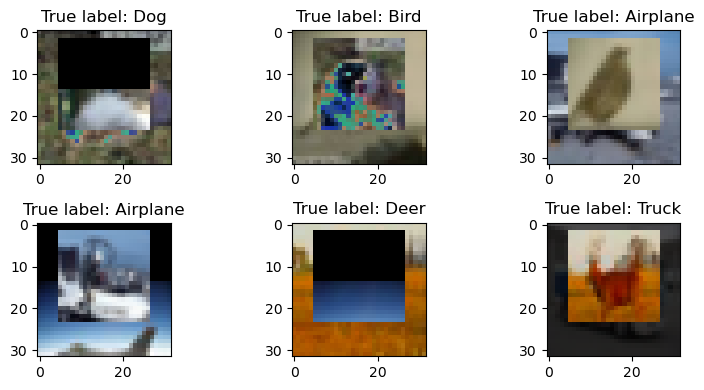

In [24]:
# Data from Data Loader

hF, vHA = plt.subplots(2, 3, figsize = (8, 4))
vHA = vHA.flat
for hA, mXX, vYY in zip(vHA, tX, mY):
    valY = torch.argmax(vYY)
    mX = torch.permute(mXX, (1, 2, 0))
    hA.imshow(torch.clip(mX * vStd[None, None, :] + vMean[None, None, :], min = 0.0, max = 1.0))
    hA.set_title(f'True label: {L_CLASSES[valY]}')
    
hF.tight_layout()

In [25]:
# Run Device

runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device


In [26]:
# Loss and Score Function

hL = nn.CrossEntropyLoss(label_smoothing = ϵ)


In [27]:
# The Score
# Adjusting the score to support the labels in a form od discrete distribution

def hS( mZ: torch.Tensor, mY: torch.Tensor ):

    numDim = mY.ndim

    vZ = torch.argmax(mZ, dim = 1)
    if numDim > 1: #<! Discrete Distribution
        vY = torch.argmax(mY, dim = 1)
    else: #<! Label as an integer
        vY = mY

    return torch.sum(torch.eq(vZ, vY)) / vZ.shape[0]

In [28]:
# Training Loop

oModel = oModel.to(runDevice)
oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-3, betas = (0.9, 0.99), weight_decay = 1e-2) #<! Define optimizer
oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-2, total_steps = numEpochs)
_, lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate = TrainModel(oModel, dlTrain, dlVal, oOpt, numEpochs, hL, hS, oSch = oSch)

Epoch    1 / 35 | Train Loss:  2.179 | Val Loss:  1.734 | Train Score:  0.242 | Val Score:  0.443 | Epoch Time: 69.53 | <-- Checkpoint! |
Epoch    2 / 35 | Train Loss:  2.049 | Val Loss:  1.625 | Train Score:  0.331 | Val Score:  0.517 | Epoch Time: 40.20 | <-- Checkpoint! |
Epoch    3 / 35 | Train Loss:  2.039 | Val Loss:  2.568 | Train Score:  0.342 | Val Score:  0.482 | Epoch Time: 45.42 |
Epoch    4 / 35 | Train Loss:  2.024 | Val Loss:  1.547 | Train Score:  0.352 | Val Score:  0.539 | Epoch Time: 41.74 | <-- Checkpoint! |
Epoch    5 / 35 | Train Loss:  1.956 | Val Loss:  1.498 | Train Score:  0.386 | Val Score:  0.558 | Epoch Time: 45.16 | <-- Checkpoint! |
Epoch    6 / 35 | Train Loss:  1.941 | Val Loss:  1.427 | Train Score:  0.402 | Val Score:  0.604 | Epoch Time: 41.91 | <-- Checkpoint! |
Epoch    7 / 35 | Train Loss:  1.937 | Val Loss:  1.494 | Train Score:  0.405 | Val Score:  0.586 | Epoch Time: 47.90 |
Epoch    8 / 35 | Train Loss:  1.911 | Val Loss:  1.472 | Train Score:

Text(0, 0.5, 'Learn Rate')

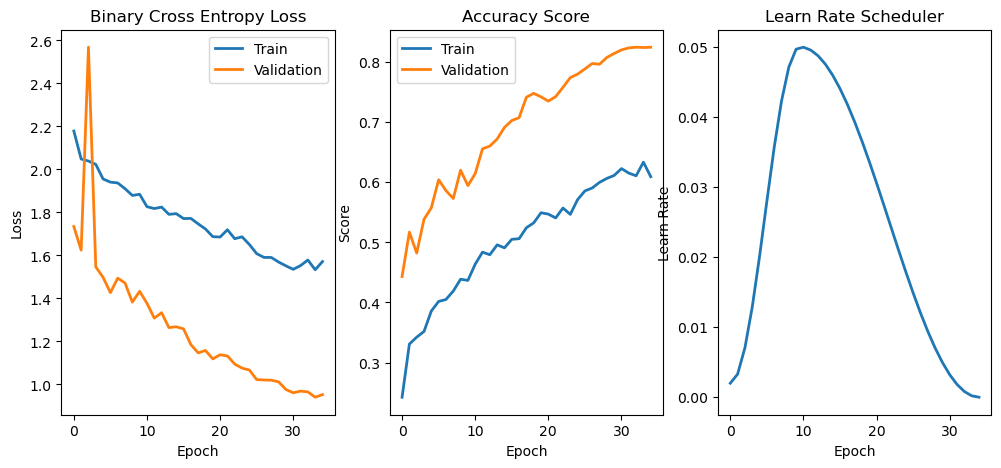

In [29]:
# Plot Training Phase

hF, vHa = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 5))
vHa = np.ravel(vHa)

hA = vHa[0]
hA.plot(lTrainLoss, lw = 2, label = 'Train')
hA.plot(lValLoss, lw = 2, label = 'Validation')
hA.set_title('Binary Cross Entropy Loss')
hA.set_xlabel('Epoch')
hA.set_ylabel('Loss')
hA.legend()

hA = vHa[1]
hA.plot(lTrainScore, lw = 2, label = 'Train')
hA.plot(lValScore, lw = 2, label = 'Validation')
hA.set_title('Accuracy Score')
hA.set_xlabel('Epoch')
hA.set_ylabel('Score')
hA.legend()

hA = vHa[2]
hA.plot(lLearnRate, lw = 2)
hA.set_title('Learn Rate Scheduler')
hA.set_xlabel('Epoch')
hA.set_ylabel('Learn Rate')

* <font color='red'>(**?**)</font> Explain the training loss vs. the validation loss.
* <font color='blue'>(**!**)</font> Replace the augmentation with `MixUp`.
* <font color='green'>(**@**)</font> Train a model based on self implementation of ResNet / ResNeXt (Use `ResidualBlock`).
* <font color='green'>(**@**)</font> Implement "Test Time" augmentation.